In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from CFG import CFG
from data_utils import load_model_paths, load_seism_paths
from dataloaders import Seism_3ch_Dataset
from Unet_model_girafe import UNet_girafe
from Unet import UNet
from train import train_model

/home/nik/miniconda3/envs/venv3-9_new2/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda:0")

In [4]:
import os
print(os.listdir("/home/nik/dataset_04_24/"))

['two_layers_perlin', 'only_spline', 'faults_simple', 'two_layers_ragged', 'faults_difficult', 'ellipse_and_two_layers']


In [5]:
BASE_PATH = "/home/nik/dataset_04_24/only_spline"

In [6]:
seism_paths = load_seism_paths(BASE_PATH=BASE_PATH)

loaded (300, 3) paths
example:
['/home/nik/dataset_04_24/only_spline/seismograms/seismogram_0/seismogram_0_0/seismogram.txt'
 '/home/nik/dataset_04_24/only_spline/seismograms/seismogram_0/seismogram_0_1/seismogram.txt'
 '/home/nik/dataset_04_24/only_spline/seismograms/seismogram_0/seismogram_0_2/seismogram.txt']


In [7]:
model_paths = load_model_paths(BASE_PATH=BASE_PATH)

loaded (300, 3) paths
example:
['/home/nik/dataset_04_24/only_spline/configs/config_0/rho_0.bin'
 '/home/nik/dataset_04_24/only_spline/configs/config_0/vp_0.bin'
 '/home/nik/dataset_04_24/only_spline/configs/config_0/vs_0.bin']


In [8]:
N_VAL = 40
N_TEST = 20
N_TRAIN = len(seism_paths) - N_VAL - N_TEST

In [9]:
train_dataset = Seism_3ch_Dataset(
    seism_paths[:N_TRAIN],
    model_paths[:N_TRAIN],
)

val_dataset = Seism_3ch_Dataset(
    seism_paths[N_TRAIN:N_TRAIN+N_VAL],
    model_paths[N_TRAIN:N_TRAIN+N_VAL],
)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, shuffle=True, persistent_workers=True, pin_memory=CFG.USE_MULTIGPU)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, shuffle=True, persistent_workers=True, pin_memory=CFG.USE_MULTIGPU)

In [11]:
def tensor_to_image(tensor):
    img = tensor.detach().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
    img = img.clip(0, 1)  # Обрезаем значения в диапазоне [0,1]
    return img

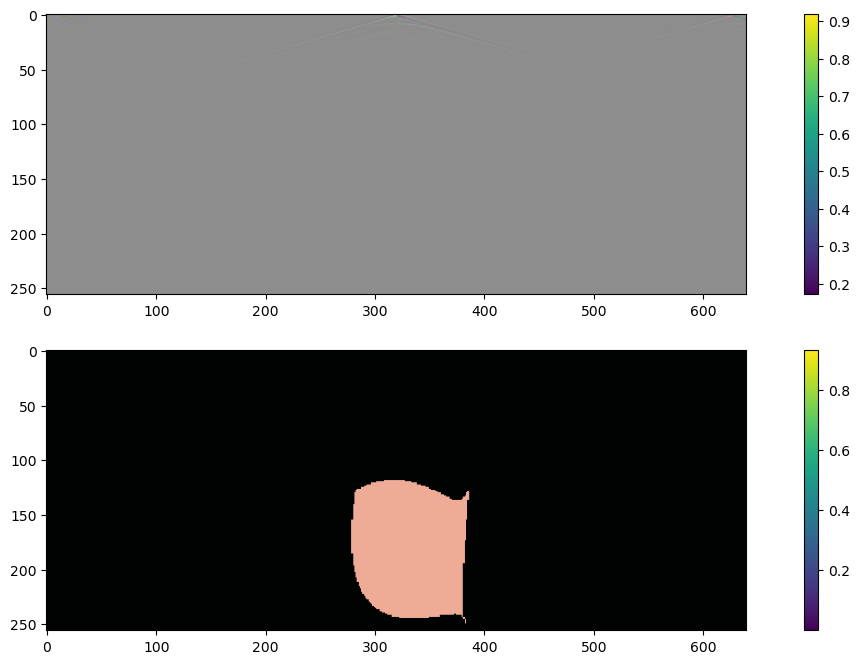

In [12]:
random_idx = random.randint(0, len(val_dataset) - 1)
image, target = train_dataset[random_idx]

image_np = tensor_to_image(image.squeeze(0))[:,:,:]   # Оригинальное изображение
target_np = tensor_to_image(target.squeeze(0))[:,:,:] # Оригинальный таргет

# Рисуем результат
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)

plt.imshow(image_np)
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(target_np)
plt.colorbar()

In [13]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight_factor=2.0, reduction='mean'):
        super(WeightedMSELoss, self).__init__()
        self.weight_factor = weight_factor
        self.reduction = reduction

    def forward(self, pred, target):
        # Вычисляем стандартный MSE
        loss = (pred - target) ** 2
        
        # Применяем взвешивание для пикселей, где target > 0.5
        weight = torch.where(target > 0.8, self.weight_factor, 1.0)
        loss = loss * weight
        
        # Применяем редукцию (по аналогии с MSELoss)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise ValueError("Invalid reduction type. Choose from 'mean', 'sum', or 'none'.")

In [14]:
model = UNet_girafe(num_classes=3).to(device)
if CFG.USE_MULTIGPU and torch.cuda.device_count() > 1:
    print("Используем несколько GPU")
    model = nn.DataParallel(model)

Используем несколько GPU


In [15]:
criterion = nn.MSELoss()
#criterion = WeightedMSELoss(weight_factor=1.35, reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)

train_model(train_loader, val_loader, model, criterion, optimizer, device)

training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.1920


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1858


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2/100], Loss: 0.1832


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1801


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3/100], Loss: 0.1771


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1753


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4/100], Loss: 0.1723


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1704


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.1676


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1654


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6/100], Loss: 0.1625


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1590


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7/100], Loss: 0.1533


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1497


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8/100], Loss: 0.1466


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1455


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9/100], Loss: 0.1422


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1423


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.1384


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1376


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [11/100], Loss: 0.1347


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1349


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [12/100], Loss: 0.1313


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1305


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [13/100], Loss: 0.1281


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1284


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [14/100], Loss: 0.1251


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1242


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [15/100], Loss: 0.1222


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1214


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [16/100], Loss: 0.1194


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1188


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [17/100], Loss: 0.1166


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1169


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [18/100], Loss: 0.1140


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1133


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [19/100], Loss: 0.1115


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1106


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.1090


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1086


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [21/100], Loss: 0.1068


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1071


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [22/100], Loss: 0.1045


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1039


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [23/100], Loss: 0.1024


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1029


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [24/100], Loss: 0.1003


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.1004


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [25/100], Loss: 0.0984


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0973


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [26/100], Loss: 0.0964


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0961


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [27/100], Loss: 0.0946


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0945


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [28/100], Loss: 0.0928


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0924


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [29/100], Loss: 0.0911


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0908


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [30/100], Loss: 0.0894


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0899


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [31/100], Loss: 0.0877


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0880


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [32/100], Loss: 0.0862


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0861


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [33/100], Loss: 0.0847


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0854


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [34/100], Loss: 0.0832


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0838


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [35/100], Loss: 0.0818


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0820


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [36/100], Loss: 0.0804


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0807


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [37/100], Loss: 0.0792


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0797


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [38/100], Loss: 0.0781


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0780


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [39/100], Loss: 0.0767


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0768


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [40/100], Loss: 0.0754


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0755


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [41/100], Loss: 0.0742


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0742


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [42/100], Loss: 0.0730


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0731


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [43/100], Loss: 0.0716


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0712


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [44/100], Loss: 0.0701


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0704


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [45/100], Loss: 0.0690


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0694


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [46/100], Loss: 0.0680


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0679


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [47/100], Loss: 0.0670


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0670


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [48/100], Loss: 0.0660


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0666


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [49/100], Loss: 0.0650


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0652


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [50/100], Loss: 0.0639


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0644


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [51/100], Loss: 0.0624


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0624


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [52/100], Loss: 0.0605


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0601


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [53/100], Loss: 0.0583


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0579


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [54/100], Loss: 0.0558


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0555


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [55/100], Loss: 0.0537


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0534


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [56/100], Loss: 0.0503


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0491


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [57/100], Loss: 0.0462


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0451


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [58/100], Loss: 0.0422


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0411


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [59/100], Loss: 0.0390


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0385


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [60/100], Loss: 0.0369


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0362


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [61/100], Loss: 0.0350


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0349


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [62/100], Loss: 0.0335


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0335


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [63/100], Loss: 0.0324


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0329


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [64/100], Loss: 0.0316


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0322


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [65/100], Loss: 0.0308


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0312


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [66/100], Loss: 0.0301


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0307


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [67/100], Loss: 0.0295


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0303


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [68/100], Loss: 0.0290


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0293


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [69/100], Loss: 0.0284


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0287


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [70/100], Loss: 0.0279


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0283


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [71/100], Loss: 0.0276


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0291


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [72/100], Loss: 0.0274


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0281


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [73/100], Loss: 0.0268


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0281


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [74/100], Loss: 0.0264


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0276


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [75/100], Loss: 0.0261


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0270


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [76/100], Loss: 0.0257


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0270


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [77/100], Loss: 0.0254


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0272


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [78/100], Loss: 0.0251


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0268


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [79/100], Loss: 0.0249


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0262


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [80/100], Loss: 0.0246


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0259


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [81/100], Loss: 0.0246


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0263


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [82/100], Loss: 0.0243


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0256


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [83/100], Loss: 0.0241


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0257


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [84/100], Loss: 0.0238


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0256


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [85/100], Loss: 0.0235


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0259


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [86/100], Loss: 0.0234


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0252


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [87/100], Loss: 0.0233


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0254


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [88/100], Loss: 0.0232


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0249


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [89/100], Loss: 0.0229


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0249


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [90/100], Loss: 0.0227


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0245


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [91/100], Loss: 0.0225


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0247


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [92/100], Loss: 0.0226


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0245


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [93/100], Loss: 0.0224


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0243


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [94/100], Loss: 0.0224


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0245


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [95/100], Loss: 0.0222


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0247


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [96/100], Loss: 0.0219


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0234


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [97/100], Loss: 0.0218


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0243


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [98/100], Loss: 0.0217


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0241


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [99/100], Loss: 0.0216


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0243


training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [100/100], Loss: 0.0214


validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation Loss: 0.0248


In [16]:
# best_model_path = "./models/best_model.pth"

# model = UNet()
# model = nn.DataParallel(model)

# model.load_state_dict(torch.load("models/best_model.pth"))
# model.to(device)

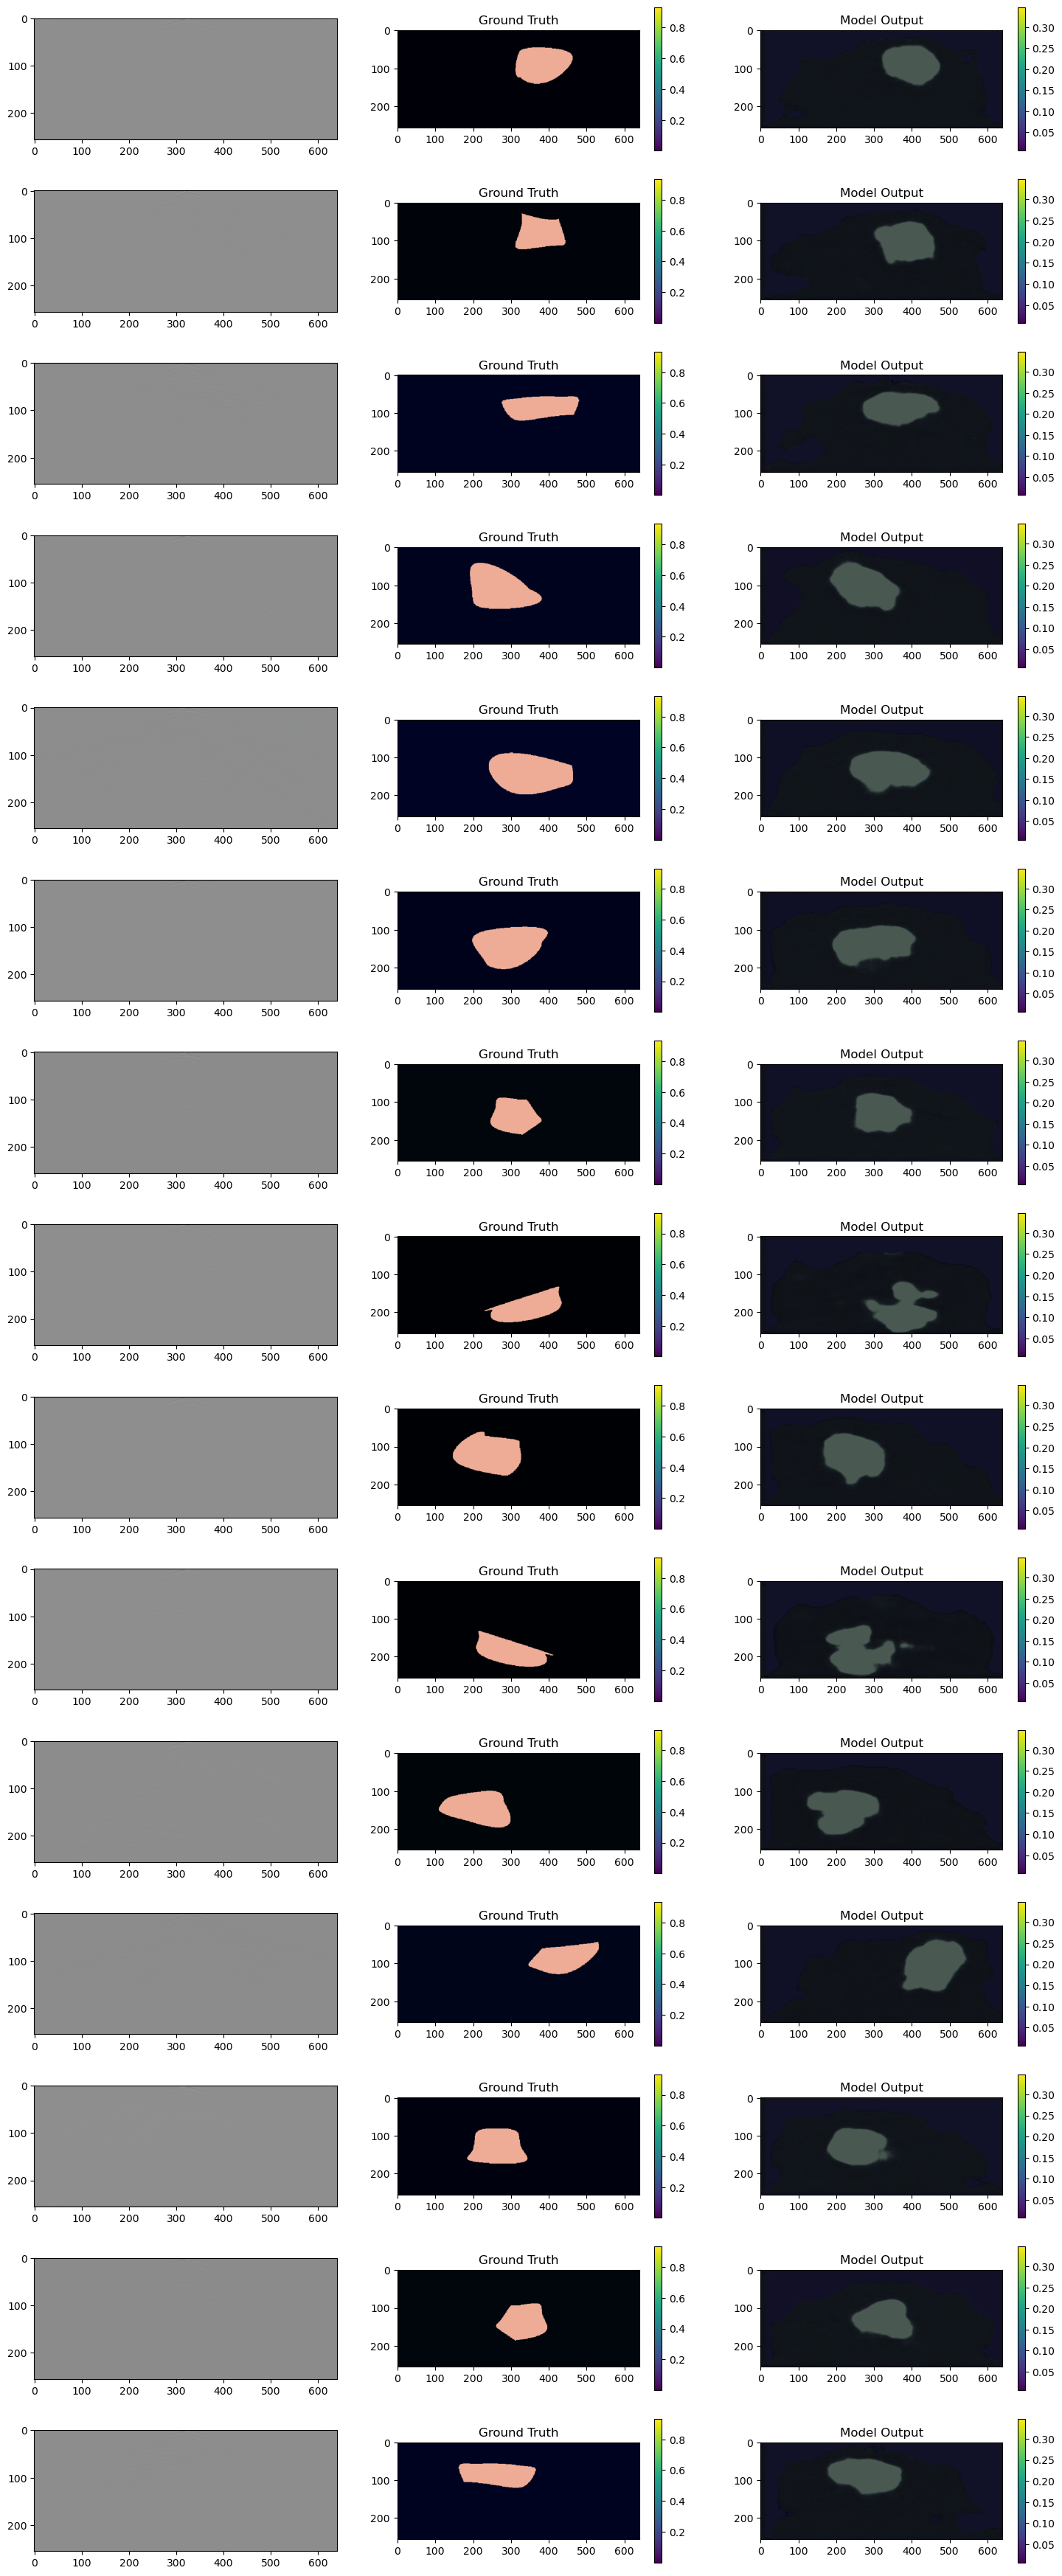

In [17]:
num_samples = 15

plt.figure(figsize=(18, int(9*num_samples/3)))
for i in range(num_samples):
    random_idx = random.randint(0, len(val_dataset) - 1)

    image, target = val_dataset[random_idx]
    image, target = image.unsqueeze(0).to(device).to(dtype=torch.float32), target.unsqueeze(0).to(device).to(dtype=torch.float32)  # Добавляем batch dim

    model.eval()
    with torch.no_grad():
        output = model(image)

    image_np = tensor_to_image(image.squeeze(0))[:,:,:]   # Оригинальное изображение
    target_np = tensor_to_image(target.squeeze(0))[:,:,:] # Оригинальный таргет
    output_np = tensor_to_image(output.squeeze(0))[:,:,:] # Предсказание модели

    # Рисуем результат
    
    plt.subplot(num_samples, 3, 1+3*(i))
    plt.imshow(image_np)
    #show_seism_log_RGB(image_np)
    plt.subplot(num_samples, 3, 2+3*(i))
    plt.imshow(target_np[:,:,:])#, interpolation='none')
    plt.colorbar()
    plt.title("Ground Truth")
    plt.subplot(num_samples, 3, 3+3*(i))
    plt.imshow(output_np[:,:,:])#, interpolation='none')
    plt.colorbar()
    plt.title("Model Output")
plt.show()